Import Useful Libraries

In [ ]:
import random
import os
import cv2
import torch
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from PIL import Image
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
import torchvision


Split Training Dataset into Train and Validation

In [ ]:
# Files paths
meta_file_dir = './Dataset/Chest_xray_Corona_Metadata.csv'
data_path = './Dataset/Tr_Test_Data'

missed = []
data_images_filenames = set(os.listdir(data_path))
# REMOVE UNLABELLED(MISSED) DATA FROM DATASET
meta_data = pd.read_csv(meta_file_dir, usecols=['X_ray_image_name', 'Label', 'Label_2_Virus_category', 'Label_1_Virus_category'])    # Read the meta_data csv file
meta_names = meta_data.X_ray_image_name.to_list()                               # List of image names  
for image_name in data_images_filenames:                                        
    if image_name not in meta_names:                                            # Check whether image name is in meta file
      missed.append(image_name)

data_images_filenames = sorted(list(data_images_filenames))
for i in missed:
  data_images_filenames.remove(i)

# PREPARE THE LABELS FOR EACH CLASS
data_df = pd.read_csv(meta_file_dir)
data_df['Label_2_Virus_category'].fillna('NA', inplace=True)                    # Fill nan values with 'NA' in csv file
# Get indexes of each case
idx_normal = data_df[data_df['Label'] == 'Normal'].index                        
idx_pnemonia = data_df[data_df['Label'] == 'Pnemonia'].index
"""
idx_ards = data_df[data_df['Label_2_Virus_category'] == 'ARDS'].index
idx_covid = data_df[data_df['Label_2_Virus_category'] == 'COVID-19'].index
idx_sars = data_df[data_df['Label_2_Virus_category'] == 'SARS'].index
idx_streptococcus = data_df[data_df['Label_2_Virus_category'] == 'Streptococcus'].index
idx_virus_NaN = data_df[(data_df['Label_1_Virus_category'] == 'Virus') & (data_df['Label_2_Virus_category'] == 'NA')].index
idx_bacteria_NaN = data_df[(data_df['Label_1_Virus_category'] == 'bacteria') & (data_df['Label_2_Virus_category'] == 'NA')].index
"""
# Get image names of specified indexes, obtain list of image names, obtain dict of image names with corresponding labels
normal_case = data_df['X_ray_image_name'][idx_normal]
normal_case = normal_case.to_list()
normal_case = {normal_case[i]:0 for i in range(len(normal_case))}

pnemonia_case = data_df['X_ray_image_name'][idx_pnemonia]
pnemonia_case = pnemonia_case.to_list()
pnemonia_case = {pnemonia_case[i]:1 for i in range(len(pnemonia_case))}
"""
covid_case = data_df['X_ray_image_name'][idx_covid]
covid_case = covid_case.to_list()
covid_case = {covid_case[i]:1 for i in range(len(covid_case))}

virus_nan = data_df['X_ray_image_name'][idx_virus_NaN]
virus_nan = virus_nan.to_list()
virus_nan = {virus_nan[i]:2 for i in range(len(virus_nan))}

bacteria_nan = data_df['X_ray_image_name'][idx_bacteria_NaN]
bacteria_nan = bacteria_nan.to_list()
bacteria_nan = {bacteria_nan[i]:3 for i in range(len(bacteria_nan))}
"""
# Merge all the dictionaries into one dict
labelled_data = {**normal_case, **pnemonia_case}

"""
# Remove data that causes to class imbalance(sars, ards, stretococcus)
ards_case = data_df['X_ray_image_name'][idx_ards]
ards_case = ards_case.to_list()
#ards_case = {ards_case[i]:1 for i in range(len(ards_case))}
sars_case = data_df['X_ray_image_name'][idx_sars]
sars_case = sars_case.to_list()
#sars_case = {sars_case[i]:4 for i in range(len(sars_case))}
streptococcus_case = data_df['X_ray_image_name'][idx_streptococcus]
streptococcus_case = streptococcus_case.to_list()
#streptococcus_case = {streptococcus_case[i]:6 for i in range(len(streptococcus_case))}

unnsecerray = ards_case + sars_case + streptococcus_case
for i in unnsecerray:
  data_images_filenames.remove(i)
"""

# Randomly create train/val/test dataset
random.seed(42)
random.shuffle(data_images_filenames)                        # Shuffle all the images in order to randmoly create train/val/test dataset

train_images_filenames = data_images_filenames[:4728]        # 80% train images
val_images_filenames = data_images_filenames[4728:-591]      # 10% val images 
test_images_filenames = data_images_filenames[-591:]         # 10% test images




print(len(train_images_filenames), len(val_images_filenames), len(test_images_filenames))
print(len(missed), len(data_images_filenames), len(meta_names))

4728 591 591
23 5910 5910


Dataset Preparation

In [ ]:

class ChestDataset(Dataset):
    def __init__(self, images_filenames, images_directory, labelled_data, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory 
        self.labelled_data = labelled_data
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_name = self.images_filenames[idx]
        image = Image.open(os.path.join(self.images_directory, image_name))     # Read an image as PIL image
        
        # Convert grayscale image to rgb image
        image = image.convert("RGB")

        # Get the corresponding label of image
        label = self.labelled_data[image_name]
           
        if self.transform is not None:
            image = self.transform(image)
            
        return image, torch.tensor(label)


image_size = 224
# Transformations
train_transforms = transforms.Compose([
                                  transforms.Resize((image_size, image_size)),
                                  #transforms.RandomCrop((224,224)),
                                  transforms.RandomHorizontalFlip(p=0.5),
                                  #transforms.RandomVerticalFlip(p=0.5),
                                  transforms.ToTensor(), 
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                         
])

# Augmentation is not applied to the validation dataset
validation_transforms = transforms.Compose([
                                            transforms.Resize((image_size, image_size)),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])          
])

test_transforms = transforms.Compose([
                                      transforms.Resize((image_size, image_size)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                    
])

# Create datasets
train_dataset = ChestDataset(train_images_filenames, data_path, labelled_data, transform=train_transforms)
validation_dataset = ChestDataset(val_images_filenames, data_path, labelled_data, transform=validation_transforms)
test_dataset = ChestDataset(test_images_filenames, data_path, labelled_data, transform=test_transforms)

In [ ]:
# Check image counts in each dataset

sifir = 0
bir = 0

for i in train_images_filenames:
  if labelled_data[i] == 0:
    sifir += 1
  elif labelled_data[i] == 1:
    bir += 1
  
print(sifir, bir)



1278 3450


###Models

Custom Model(Corona Net)

In [ ]:
def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.0)




class Corona_Net(nn.Module):
  def __init__(self, in_channel=3, out_channel=32):
    super(Corona_Net, self).__init__()

    self.conv = nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channel),
        
        nn.Conv2d(out_channel, 64, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2,stride=2),
        
        nn.Conv2d(64, 128, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(128),
        
        nn.Conv2d(128, 128, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=2,stride=2),
        
        nn.Conv2d(128, 128, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(128),
        
        nn.Conv2d(128, 256, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=2,stride=2))
    self.conv.apply(init_weights)

    
    
    self.linear = nn.Sequential(
        nn.Linear(256*24*24,512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128,2)  )
                                  
    self.linear.apply(init_weights)
  
  def forward(self, image):
    
    out = self.conv(image)

    out = out.view(-1, 256*24*24)                    # Flattening the conv output

    out = self.linear(out)

    return out


if __name__ == '__main__':
    image = torch.rand((1, 3, 224, 224))
    model = Corona_Net()    #.to('cuda')
    print(model(image).size())
  
    

torch.Size([1, 2])


Inception-V3

In [ ]:
def freeze_some_parameters(model):

  for i, child in enumerate(model):
    if i < 16:                                                                  # Set the ith layer and freeze all the layers up to the ith layer
      for param in child.parameters():
        param.requires_grad = False

inception = torchvision.models.inception_v3(pretrained=True, aux_logits=False)
model_layers = list(inception.children())
freeze_some_parameters(model_layers)
num_classes = 2

num_ftrs = inception.fc.in_features
inception.fc = nn.Linear(num_ftrs,num_classes)
#input_size = 299

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


ResNet-18

In [ ]:
import torchvision

def freeze_some_parameters(model):

  for i, child in enumerate(model):
    if i < 6:                                                                   # Set the ith layer and freeze all the layers up to the ith layer
      for param in child.parameters():
        param.requires_grad = False

resnet = torchvision.models.resnet18(pretrained=True)
num_filters = resnet.fc.in_features
resnet.fc = nn.Linear(num_filters, 2)

model_layers = list(resnet.children())
freeze_some_parameters(model_layers)

if __name__ == '__main__':
    image = torch.rand((1, 3, 500, 500))
    model = resnet
    #print(model(image).size())
model_layers[8]

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


AdaptiveAvgPool2d(output_size=(1, 1))

###Train and Evaluate

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    
    model.train()
    running_loss = 0.0
    total = 0.
    correct = 0.
    for i, (images, target) in enumerate(train_loader):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True)
        output = model(images)
        loss = criterion(output, target)
        
        running_loss += float(loss.item()) * images.size(0)           
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted==target).sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    epoch_acc = 100 * correct / total      
    epoch_loss = running_loss / len(train_loader.dataset)
    print('Epoch: {}, Tr_Loss: {}, Tr_Acc: {}'.format(epoch, epoch_loss, epoch_acc))
    return epoch_loss, epoch_acc 

In [ ]:
def validate(val_loader, model, criterion, epoch, params):
    
    model.eval()
    
    running_loss = 0.0
    total = 0.
    correct = 0.
    with torch.no_grad():
        for i, (images, target) in enumerate(val_loader):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True)
            output = model(images)
            loss = criterion(output, target)
            
            running_loss += float(loss.item()) * images.size(0)                 
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted==target).sum().item()            
            
    epoch_loss = running_loss / len(val_loader.dataset)
    
    epoch_acc = 100 * correct / total
    print('Epoch: {}, Val_Loss: {}, Val_Acc: {}'.format(epoch, epoch_loss, epoch_acc))
    return epoch_loss, epoch_acc 

In [ ]:
def create_model(params):
    model = resnet  
    model = model.to(params["device"])
    return model



# Weighting the classes(for solving class imbalance in dataset)
nSamples = torch.tensor([1274, 3447])
class_weights = (1.0 - nSamples / nSamples.sum()).to('cuda')


def train_and_validate(model, train_dataset, validation_dataset, params, weights):
    train_loss = [] 
    valid_loss = []
    valid_acc = []
    train_acc = []
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=params["batch_size"],
        shuffle=True,
        num_workers=params["num_workers"],
        pin_memory=True
    )
    val_loader = DataLoader(
        validation_dataset,
        batch_size=params["batch_size"],
        shuffle=False,
        num_workers=params["num_workers"],
        pin_memory=True
    )
   
    criterion = nn.CrossEntropyLoss(weight=weights).to(params["device"]) 
    optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])    # with L2 regularization
    scheduler  = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)                           # lr scheduler
    for epoch in range(params["epochs"]):
        tr_loss, tr_acc = train(train_loader, model, criterion, optimizer, epoch, params)
        val_loss, val_acc = validate(val_loader, model, criterion, epoch, params)
        scheduler.step()
        
        train_loss.append(tr_loss)
        train_acc.append(tr_acc)
        valid_loss.append(val_loss)
        valid_acc.append(val_acc)
        
    
    
    stat = {'val_loss':valid_loss, 'tr_loss':train_loss, 'val_acc':valid_acc, 'tr_acc':train_acc} 
    
    return model, stat


###Test the Model

Test Accuracy = 94.41624365482234 %
Confusion Matrix:  [[149  11]
 [ 22 409]]
Report:                precision    recall  f1-score   support

           0       0.87      0.93      0.90       160
           1       0.97      0.95      0.96       431

    accuracy                           0.94       591
   macro avg       0.92      0.94      0.93       591
weighted avg       0.95      0.94      0.94       591



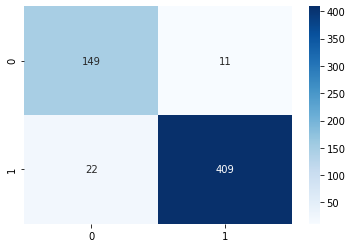

In [ ]:
model.eval()
total = 0.
correct = 0.
predict = []
actual = []

test_loader = DataLoader(
        test_dataset,
        batch_size=params["batch_size"],
        shuffle=False,
        num_workers=params["num_workers"],
        pin_memory=True)

with torch.no_grad():
    predictions = torch.tensor([]).cuda()
    targets = torch.tensor([]).cuda()
    for data in test_loader:
        img, label = data
        img = img.cuda()
        label = label.cuda()
        output = model(img)
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted==label).sum().item()
        predictions = torch.cat((predictions, predicted), dim=0)
        targets = torch.cat((targets, label), dim=0)
    test_acc = 100 * correct / total
    cf_matrix = confusion_matrix(targets.cpu(), predictions.cpu(), labels=[0,1])
    report = classification_report(targets.cpu(),predictions.cpu(), labels=[0,1])  
print('Test Accuracy = {} %'.format(test_acc))
print('Confusion Matrix: ', cf_matrix)
print('Report: ', report)
sns.heatmap(cf_matrix, fmt='2', annot=True, cmap='Blues') 

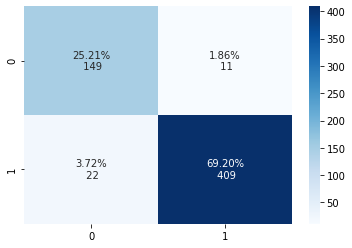

In [ ]:
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
labels = [f'{v1}\n {v2}' for v1, v2 in
          zip(group_percentages, group_counts)]
    
labels = np.asarray(labels).reshape(2,2)
s_plot = sns.heatmap(cf_matrix, fmt='2', annot=labels, cmap='Blues') # fmt='.2%'
fig = s_plot.get_figure()
fig.savefig('./Inception_Cmatrix')


Parameters for Custom Model

In [ ]:
params = {
    "model":Corona_Net(),
    "device": "cuda",
    "lr": 1e-3,
    "batch_size": 128,
    "num_workers": 4,
    "epochs": 20,
    "weight_decay":1e-2
}


Parameters for Transfer Learning

In [ ]:
params = {
    "model":resnet,
    "device": "cuda",
    "lr": 1e-5,
    "batch_size": 128,
    "num_workers": 4,
    "epochs": 20,
    "weight_decay":0
}


In [ ]:

# Create and Train a model
model = create_model(params)
model, stat = train_and_validate(model, train_dataset, validation_dataset, params, class_weights)


Epoch: 0, Tr_Loss: 0.3809017570793326, Tr_Acc: 88.04991539763114
Epoch: 0, Val_Loss: 0.4460820925820701, Val_Acc: 86.80203045685279
Epoch: 1, Tr_Loss: 0.18294337361597168, Tr_Acc: 92.76649746192894
Epoch: 1, Val_Loss: 0.12884419276528755, Val_Acc: 96.1082910321489
Epoch: 2, Tr_Loss: 0.13995241185937032, Tr_Acc: 94.9238578680203
Epoch: 2, Val_Loss: 0.11312479136256397, Val_Acc: 96.27749576988155
Epoch: 3, Tr_Loss: 0.1145672190512094, Tr_Acc: 96.17174280879864
Epoch: 3, Val_Loss: 0.09146080182490211, Val_Acc: 97.46192893401015
Epoch: 4, Tr_Loss: 0.09621645532888809, Tr_Acc: 96.9331641285956
Epoch: 4, Val_Loss: 0.08076065384141483, Val_Acc: 97.12351945854483
Epoch: 5, Tr_Loss: 0.08541431636021625, Tr_Acc: 97.25042301184433
Epoch: 5, Val_Loss: 0.07413570010520884, Val_Acc: 97.6311336717428
Epoch: 6, Tr_Loss: 0.07007209151075576, Tr_Acc: 97.60998307952623
Epoch: 6, Val_Loss: 0.07024371516835669, Val_Acc: 97.96954314720813
Epoch: 7, Tr_Loss: 0.06028185048583397, Tr_Acc: 98.3502538071066
Epoc

In [ ]:
# Save the model weights
torch.save(model.state_dict(), './ResNet_Binary.ckpt')

Training Statistics

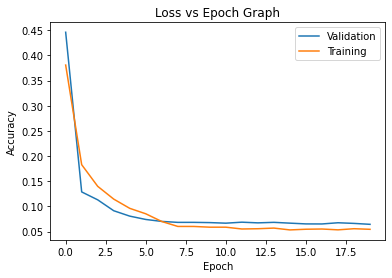

In [ ]:
tr_loss = stat['tr_loss']
val_loss = stat['val_loss']
plt.plot(val_loss, label='Validation')
plt.plot(tr_loss, label='Training')
plt.title('Loss vs Epoch Graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#plt.savefig('./Acc_Custom.png')
#print('Last Validation Accuracy:', val_loss[-1])